In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from scipy.sparse import diags
from tangelo.linq.helpers.circuits.statevector import StateVector
from tangelo.linq import get_backend, Circuit, Gate
import math
from itertools import product
from openfermion import get_sparse_operator, get_ground_state
from tangelo.toolboxes.operators import QubitOperator
import numpy as np
from numpy import pi, exp
from tangelo.toolboxes.ansatz_generator.ansatz_utils import get_qft_circuit
from tangelo.toolboxes.ansatz_generator.ansatz_utils import pauli_op_to_gate, recursive_trotter_suzuki_decomposition
from tangelo.toolboxes.circuits.lcu import sign_flip

In [2]:
lam_eh = 0.7
lam_ee = 4
lam_eli = 2.25


def vpot_harm(xpts, r):
    return 1/2*r*xpts**2

def vinteract_harm(xpts):
    n1=len(xpts)
    fullgrid = np.zeros(n1**2, dtype=float)
    for n in range(n1):
        fullgrid[n*n1:(n+1)*n1] = 1/np.sqrt(lam_ee+(xpts[n]-xpts)**2)
    return fullgrid

def qu_vpot(vals, order='lsq_first'):
    n_qubits=round(math.log2(len(vals)))
    new_vals = vals.copy()
    if order == "msq_first":
        new_vals = new_vals.reshape([2]*n_qubits).transpose(list(reversed(range(n_qubits)))).flatten() 
    v_op =QubitOperator()
    for i in product(["I", "Z"], repeat=n_qubits):
        tup = tuple([(j, op) for j, op in enumerate(i) if op != "I"])
        qu_op = QubitOperator(tup)
        v = get_sparse_operator(qu_op, n_qubits=n_qubits)
        v_op += (diags(new_vals).dot(v)).trace()*QubitOperator(tup)
    v_op /= 2**n_qubits
    return v_op

In [3]:
from scipy.linalg import dft
n_pts_s = 10
dx_s = 0.8
dp = 2*np.pi/n_pts_s/dx_s
p = np.empty(n_pts_s, dtype=float)
for i in range(n_pts_s):
    p[i] = dp*i - (n_pts_s//2)*dp
ptot_s = np.diag(p**2)
dvrpts_s = np.linspace(-dx_s*(n_pts_s//2-1/2), dx_s*(n_pts_s//2-1/2), n_pts_s)
dftmat = dft(n_pts_s, 'sqrtn')
p2mat= 1/2*np.diag(ptot_s)
tfft = np.transpose(np.conj(dftmat))@np.diag(p2mat)@dftmat

print(np.linalg.eigh(tfft+np.diag(1/2*dvrpts_s**2))[0])
#rval = 0.25
#one_body_integrals = np.diag(vpot_harm(dvrpts_s, 1)) + tfft
#two_body_coeff = vinteract_harm(dvrpts_s)
#two_body_integrals = np.zeros((n_pts_s, n_pts_s, n_pts_s, n_pts_s))
#from itertools import product
#for i, j in product(range(n_pts_s), repeat=2):
#    #two_body_integrals[i, j, j, i] = two_body_coeff[i*n_pts_s + j]
#    two_body_integrals[i, j, j, i] = two_body_coeff[i*n_pts_s + j]
#from openfermion.chem.molecular_data import spinorb_from_spatial
#one_body_tensor, two_body_tensor = spinorb_from_spatial(one_body_integrals.real, two_body_integrals.real)
#from openfermion import InteractionOperator, get_fermion_operator, get_sparse_operator, get_ground_state
#from tangelo.toolboxes.qubit_mappings.mapping_transform import fermion_to_qubit_mapping
#mol_ham = get_fermion_operator(InteractionOperator(0, one_body_tensor.real, two_body_tensor.real/2))
#mol_qu = fermion_to_qubit_mapping(mol_ham, "jw", up_then_down=True, n_spinorbitals=n_pts_s*2, spin=2, n_electrons=4)
#print(mol_qu)


[ 0.50000023  1.49999281  2.50005362  3.49937376  4.49904381  5.48601308
  6.42138249  7.60202837  8.53227397 12.07597455]


In [4]:
#sp_op = get_sparse_operator(mol_qu)
#from scipy.sparse.linalg import eigsh
#import scipy
#values, vectors = scipy.sparse.linalg.eigsh(sp_op,
#                                                k=80,
#                                                which='SA',
#                                                maxiter=2000, tol=1.e-14)

# print(values)

In [5]:
#fdict = dict()
#for vnum in range(45, 75):
#    for i, val in enumerate(vectors[:,vnum]):
#        if (np.abs(val) > 1.e-8):
#            #print(np.binary_repr(i, width=n_pts_s*2), np.abs(val))
#            
#            fdict[str(np.binary_repr(i, width=n_pts_s*2))] = (val.conj()*val).real
#            if sum([int(i) for i in str(np.binary_repr(i, width=n_pts_s*2))]) == 4:
#                print(values[vnum], str(np.binary_repr(i, width=n_pts_s*2)))
#                print(vnum, sum([int(i) for i in str(np.binary_repr(i, width=n_pts_s*2))]))
#            break

#from tangelo.toolboxes.post_processing.histogram import Histogram


#d = np.zeros(n_pts_s)
#for i in range(n_pts_s):
#    hist = Histogram(fdict)
#    hist.remove_qubit_indices(*[j for j in range(n_pts_s*2) if j != i])
#    d[i]  = hist.frequencies['1']

#import matplotlib.pyplot as plt
#plt.plot(d)

In [6]:
#v4 = vectors[:, 54].copy()

In [7]:
import sys
sys.path.append("/Users/jamesbrown/Documents/Coding/TDDFTinversion/python")


import TDDFTinversion as td

In [8]:
np1=n_pts_s*2 #number of grid points for 1-dimension
#initialize systemparameters derived type
sysparams=td.derivedtypes.init_systemparameters(np1)
sysparams.nd=1 #number of dimensions
sysparams.npart=4 #number of particles
sysparams.xmin=0 #minimum grid point
sysparams.xmax=2*n_pts_s-1 #maximum grid point
sysparams.ct=0. #starting time
sysparams.dth=0.012 #goal time step
sysparams.dvksmax=1000 #max derivative of density with respect to time
sysparams.pinv0minresqlp1=1 #pseudoinverse set to 0, minresqlp set to 1
sysparams.quantization=2 #Quantization
sysparams.energy=5.5 #Energy of KS system, this can if desired
td.derivedtypes.fill_systemparameters(sysparams)
td.keomod.buildkeo(sysparams) #build kinetic energy operator and lattice values

n_steps = 5000
ttime = sysparams.dth*n_steps

print(n_pts_s)
sysparams.t[:,:] = sysparams.t*0#(np.kron(np.eye(2), tfft.real))
for i in range(n_pts_s):
    for j in range(n_pts_s):
        sysparams.t[i, j] = tfft[i, j].real
        sysparams.t[i+ n_pts_s, j+ n_pts_s] = tfft[i, j].real

10


In [9]:
import itertools
#generate derived type to store 1 and 2 body potentials
sharedvals=td.derivedtypes.init_sharedvalues(sysparams) #shared values derived type
print(np.shape(sharedvals.vinteract))
#generate potentials, can write own program
td.potential.generate_1bodypot(sysparams,sharedvals)
td.potential.generate_2bodypot(sysparams,sharedvals)
sharedvals.vinteract[:] = 0
for i, j in itertools.product(range(2*n_pts_s), repeat=2):
    sharedvals.vinteract[j+i*2*n_pts_s] = 1/np.sqrt(lam_ee+(dvrpts_s[j%n_pts_s]-dvrpts_s[i%n_pts_s])**2)#two_body_tensor[i, j, j, i]
    #print(i,j, two_body_tensor[i,j,j,i], 1/np.sqrt(2+(dvrpts_s[j%n_pts_s]-dvrpts_s[i%n_pts_s])**2))
o = np.array([1, 0])
z = np.array([0, 1])
sharedvals.vin[:] = np.kron(z, vpot_harm(dvrpts_s, 1)) + np.kron(o, vpot_harm(dvrpts_s, 1))

#for i in range(n_pts_s):
#    sharedvals.vin[i] = vpot_harm(dvrpts_s, 1)[i]
#    sharedvals.vin[i+n_pts_s] = vpot_harm(dvrpts_s, 1)[i]
sharedvals.v1[:] = sharedvals.vin[:]

#derived type that stores full wavefunction and potential
fullvals=td.derivedtypes.init_fullvalues(sysparams)
td.potential.generate_nbodypot(sysparams,sharedvals,fullvals)
td.initial_states.initializefullsystem(sysparams,fullvals)
sharedvals.vin[:] = np.kron(z, vpot_harm(dvrpts_s, 1)) + np.kron(o, vpot_harm(dvrpts_s, 1))

#for i in range(n_pts_s):
#    sharedvals.vin[i] = vpot_harm(dvrpts_s, 1)[i]
#    sharedvals.vin[i+n_pts_s] = vpot_harm(dvrpts_s, 1)[i]
sharedvals.v1[:] = sharedvals.vin[:]

(400,)


In [10]:
td.secondquant_wrap.calc_ground_state(sysparams, sharedvals, 2*n_pts_s, 30, fullvals.psi)

 infunction
 eig   6.4812311987794651        7.3968441093164827        7.3968441093164827        7.3968441093165076        7.4808216324133765     


In [11]:
one_rdm_full = np.zeros((sysparams.np1, sysparams.np1), dtype=np.complex128, order="F")
td.secondquant_wrap.onerdm(sysparams, sysparams.np1, fullvals.psi, one_rdm_full)

In [12]:
rdm1 = np.zeros((n_pts_s, n_pts_s), dtype=np.float64, order="F")
import itertools
for i, j in itertools.product(range(sysparams.np1), repeat=2):
    rdm1[i%n_pts_s, j%n_pts_s] += one_rdm_full[i, j].real

In [13]:
import itertools
from tangelo.linq.target.backend import Backend
from tangelo.toolboxes.qubit_mappings.mapping_transform import fermion_to_qubit_mapping
from typing import Type
from tangelo.toolboxes.operators import FermionOperator
from tangelo.linq.helpers.circuits import measurement_basis_gates
def get_rdm(ref_state, ferm_ham, backend: Type[Backend], sum_spin=True, qubit_mapping="JW", up_then_down=True, n_spinorbitals=None):
        """Compute the 1- and 2- RDM matrices using the VQE energy evaluation.
        This method allows to combine the DMET problem decomposition technique
        with the VQE as an electronic structure solver. The RDMs are computed by
        using each fermionic Hamiltonian term, transforming them and computing
        the elements one-by-one. Note that the Hamiltonian coefficients will not
        be multiplied as in the energy evaluation. The first element of the
        Hamiltonian is the nuclear repulsion energy term, not the Hamiltonian
        term.

        Args:
            var_params (numpy.array or list): variational parameters to use for
                rdm calculation
            resample (bool): Whether to resample saved frequencies. get_rdm with
                savefrequencies=True must be called or a dictionary for each
                qubit terms' frequencies must be set to self.rdm_freq_dict
            sum_spin (bool): If True, the spin-summed 1-RDM and 2-RDM will be
                returned. If False, the full 1-RDM and 2-RDM will be returned.
            ref_state (Circuit): A reference state preparation circuit.

        Returns:
            (numpy.array, numpy.array): One & two-particle spin summed RDMs if
                sumspin=True or the full One & two-Particle RDMs if
                sumspin=False.
        """

        # Initialize the RDM arrays
        n_mol_orbitals = n_spinorbitals//2
        n_spin_orbitals = n_spinorbitals
        rdm1_spin = np.zeros((n_spin_orbitals,) * 2, dtype=complex)
        rdm2_spin = np.zeros((n_spin_orbitals,) * 4, dtype=complex)

        # If resampling is requested, check that a previous savefrequencies run has been called
        qb_freq_dict = dict()
        qb_expect_dict = dict()

        # Loop over each element of Hamiltonian (non-zero value)
        for key in ferm_ham.terms:
            # Ignore constant / empty term
            if not key:
                continue

            # Assign indices depending on one- or two-body term
            length = len(key)
            if (length == 2):
                iele, jele = (int(ele[0]) for ele in tuple(key[0:2]))
            elif (length == 4):
                iele, jele, kele, lele = (int(ele[0]) for ele in tuple(key[0:4]))

            # Create the Hamiltonian with the correct key (Set coefficient to one)
            hamiltonian_temp = FermionOperator(key)

            # Obtain qubit Hamiltonian
            qubit_hamiltonian2 = fermion_to_qubit_mapping(fermion_operator=hamiltonian_temp,
                                                          mapping=qubit_mapping,
                                                          n_spinorbitals=n_spin_orbitals,
                                                          up_then_down=up_then_down)
            qubit_hamiltonian2.compress()

            # Run through each qubit term separately, use previously calculated result for the qubit term or
            # calculate and save results for that qubit term
            opt_energy2 = 0.
            for qb_term, qb_coef in qubit_hamiltonian2.terms.items():
                if qb_term:
                    if qb_term not in qb_freq_dict:
                        basis_circuit = Circuit(measurement_basis_gates(qb_term), n_qubits=n_spin_orbitals)
                        full_circuit = Circuit(n_qubits=n_spinorbitals)
                        qb_freq_dict[qb_term], _ = backend.simulate(full_circuit+basis_circuit, initial_statevector=ref_state)
                    
                    if qb_term not in qb_expect_dict:
                        qb_expect_dict[qb_term] = backend.get_expectation_value_from_frequencies_oneterm(qb_term, qb_freq_dict[qb_term])
                    expectation = qb_expect_dict[qb_term]
                    opt_energy2 += qb_coef * expectation
                else:
                    opt_energy2 += qb_coef

            # Put the values in np arrays (differentiate 1- and 2-RDM)
            if length == 2:
                rdm1_spin[iele, jele] += opt_energy2
            elif length == 4:
                rdm2_spin[iele, lele, jele, kele] += opt_energy2

        # save rdm frequency dictionary
        rdm_freq_dict = qb_freq_dict

        if sum_spin:
            rdm1_np = np.zeros((n_mol_orbitals,) * 2, dtype=np.complex128)
            rdm2_np = np.zeros((n_mol_orbitals,) * 4, dtype=np.complex128)

            # Construct spin-summed 1-RDM
            for i, j in itertools.product(range(n_spin_orbitals), repeat=2):
                rdm1_np[i//2, j//2] += rdm1_spin[i, j]

            # Construct spin-summed 2-RDM
            for i, j, k, l in itertools.product(range(n_spin_orbitals), repeat=4):
                rdm2_np[i//2, j//2, k//2, l//2] += rdm2_spin[i, j, k, l]

            return rdm1_np, rdm2_np

        return rdm1_spin, rdm2_spin


In [14]:
#from tangelo.linq.target import CirqSimulator
#sim = CirqSimulator()

In [15]:
#rdm1, rdm2 = get_rdm(v4, mol_ham, sim, sum_spin=True, qubit_mapping="JW", up_then_down=True, n_spinorbitals=16)

In [16]:
#import matplotlib.pyplot as pl
#pl.plot(np.diag(rdm1.real).reshape(8,2).T.flatten())

In [17]:
from scipy.sparse.linalg import eigsh
from scipy.sparse import kron,eye
import matplotlib.pyplot as pl
import matplotlib.animation as manimation
from scipy.optimize import minimize

4.000000000000005
      fun: 0.001506872941542614
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.19192257e-10,  1.52905175e-09, -6.88442786e-09, -3.15120308e-09,
        3.17814963e-09, -2.56457144e-09,  4.57758709e-09,  1.29762651e-09,
        3.44853064e-09, -1.17297488e-09])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 60
      nit: 37
     njev: 60
   status: 0
  success: True
        x: array([0.06310418, 0.37468016, 0.95613895, 1.034105  , 0.61615836,
       0.61615835, 1.034105  , 0.95613895, 0.37468016, 0.06310417])
[0.00963603 0.09407364 0.4248325  0.92340431 0.97872321 0.97872321
 0.92340431 0.4248325  0.09407364 0.00963603]
1.0
7.161974564360679e-09


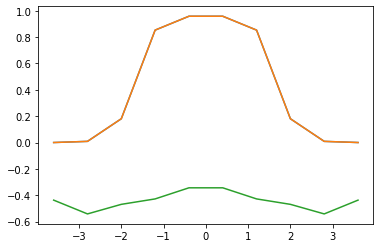

4.000000000000001


In [18]:
one_rdm = rdm1.copy().real
goal_d = np.diag(one_rdm.real)
print(sum(goal_d))
def func(vp, t, rdm):
    first_part = np.trace(np.matmul(t + np.diag(vp/np.sqrt(np.diag(rdm))), rdm))
    e, phi = eigsh(t + np.diag(vp/np.sqrt(np.diag(rdm))), k=2, which='SA')
    return first_part - 2*e[0]-2*e[1]
def jac(vp, t, rdm):
    jacvals = np.zeros(len(vp))
    e, phi = eigsh(t + np.diag(vp/np.sqrt(np.diag(rdm))), k=2, which='SA')
    for i, v in enumerate(vp):
        jacvals[i] = rdm[i,i]/np.sqrt(rdm[i,i])
        jacvals[i] -= (2*phi[i,0]**2+2*phi[i,1]**2)/np.sqrt(rdm[i,i])
    return jacvals
vpar = np.sqrt(np.diag(one_rdm))
result = minimize(func, vpar, args=(tfft.real, one_rdm), jac=jac, method="L-BFGS-B", tol=1.e-14, options={"disp": False, "maxiter": 1000, "gtol": 1e-9})
print(result)
print(vpar)
#pl.plot(dvrpts_s, result.x/np.sqrt(np.diag(one_rdm))-vpot_harm(dvrpts_s, 1))

e, phi = eigsh(tfft.real + np.diag(result.x/np.sqrt(np.diag(one_rdm))), k=2, which="SA")

print(np.linalg.norm(phi[:, 0]))
print(np.linalg.norm((2*phi[:,0]*phi[:,0]+2*phi[:,1]*phi[:,1]).flatten().real-goal_d))
coul = vinteract_harm(dvrpts_s).reshape((n_pts_s, n_pts_s))@goal_d
pl.plot(dvrpts_s, (2*phi[:,0]*phi[:,0]+2*phi[:,1]*phi[:,1]).flatten().real, dvrpts_s, goal_d, dvrpts_s, result.x/np.sqrt(np.diag(one_rdm))-1*vpot_harm(dvrpts_s, 1)-coul/2)
pl.show()
print(sum((2*(phi[:,0]**2)+2*(phi[:,1]**2)).flatten().real))

In [19]:
#next 5 are required to develop and advance KS orbitals
dpe=np.zeros(sysparams.ntot1,dtype=np.float64) #current density
dnx=np.zeros(sysparams.ntot1,dtype=np.float64) #current derivative of density
ddnx=np.zeros(sysparams.ntot1,dtype=np.float64) #second derivative of density
dpenew=np.zeros(sysparams.ntot1,dtype=np.float64) #density after time step dt, taken from sysparams.dt
ddnxnew=np.zeros(sysparams.ntot1,dtype=np.float64) #second derivative of density after time step sysparams.dt

#placeholder for advancing full system
psinew=np.zeros(sysparams.ntot,dtype=np.complex128)
psinew2 = np.zeros(sysparams.ntot, dtype=np.complex128)


td.density.fullwf_density(sysparams,fullvals.psi,dpe)

#initialize KS orbitals system to match dpe
KSvals=td.initial_states.initializekssystem(sysparams,sharedvals,dpe,fullvals)
o = np.array([1, 0])
z = np.array([0, 1])
KSvals.phi[:, 0] = np.kron(o, phi[:, 0])
KSvals.phi[:, 1] = np.kron(z,phi[:, 0])
KSvals.phi[:, 2] = np.kron(o,phi[:, 1])
KSvals.phi[:, 3] = np.kron(z,phi[:, 1])
vks1 = result.x/np.sqrt(np.diag(one_rdm))
print(vks1)
KSvals.vks[:] = np.kron(o, vks1) + np.kron(z, vks1)
sharedvals.vin[:] = np.kron(o, vpot_harm(dvrpts_s, 1)) + np.kron(z, vpot_harm(dvrpts_s, 1))
sharedvals.v1[:] = sharedvals.vin[:]


[6.54877354 3.98283888 2.25062573 1.11988322 0.62955323 0.62955323
 1.11988323 2.25062574 3.98283889 6.54877316] Calculating initial corresponding KS state



In [20]:
def makefocklist(M,N):
    # integer, intent(in) :: M,N
    # integer, allocatable :: plist(:,:),flist(:,:)
    # integer, intent(out) :: tot
    # integer:: the_list(M),str_builder(N),jin,prev,l
    the_list = np.zeros(M, dtype=int)
    for l in range(M):
       the_list[l]=l+1
    jin=0
    prev=0 
    tot=[]
    #countnchoosek(M,N,jin,prev,tot)
    str_builder = [0]*N
    
    plist = []
    jin = 0
    prev = 0
    tot = []
    buildnchoosek(the_list,N,str_builder,plist,jin,prev,tot)
    return plist
def countnchoosek(size_the_list,kin,j,prev,tot):
    if (j==kin):
      tot += [1]
      return
    else:
       for i in range(prev+1,size_the_list+1):
          j=j+1
          countnchoosek(size_the_list,kin,j,i,tot)
          j=j-1

def buildnchoosek(the_list,kin,str_builder,plist,j,prev,tot):
    if (j==kin):
       tot+= [1]
       plist += [str_builder.copy()]
       return
    else:
       for i in range(prev+1, len(the_list)+1):
          j=j+1
          str_builder[j-1] = the_list[i-1]
          buildnchoosek(the_list,kin,str_builder,plist,j,i,tot)
          j=j-1

occlist = makefocklist(2*n_pts_s, sysparams.npart)
print(len(occlist))
print(sysparams.ntot)

4845
4845


In [21]:
#str_rep_dict = dict()
#for j, occ in enumerate(occlist):
#    str_rep = ""
#    for i in range(2*n_pts_s):
#        str_rep += "1" if i+1 in occ else "0"
#    str_rep_dict[str_rep] = j


In [22]:
#fullvals.psi *= 0
#for i, val in enumerate(v4):
#        if (np.abs(val) > 1.e-1):
#            #print(np.binary_repr(i, width=n_pts_s*2), np.abs(val))
#            
#            str_rep = str(np.binary_repr(i, width=n_pts_s*2))
#
#            #fullvals.psi[str_rep_dict[str_rep]] = val
#            print(fullvals.psi[str_rep_dict[str_rep]], val)
#fullvals.psi *= 0
#for i, val in enumerate(fullvals.psi):
#    if (np.abs(val) > 1.e-1):
#        print(occlist[i], val)

[-3.82823547e-17  1.28234680e-16  2.49589103e-15  1.26355964e-15
 -8.43253117e-15 -8.32224737e-15  4.95422238e-16 -7.85462356e-16
 -3.47495193e-16  4.95426438e-17 -3.22732049e-17  4.44233106e-16
 -2.01797486e-16 -6.94360859e-16 -3.82144577e-15 -9.36129735e-15
  7.36880749e-16 -2.30562460e-16 -3.49582290e-16  1.68373437e-17]


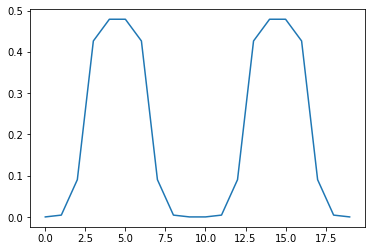

In [23]:
import matplotlib.pyplot as pl
td.density.calcddnx(sysparams,sharedvals,sysparams.ntot1,fullvals.psi,fullvals.v,ddnx)
td.density.fullwf_density(sysparams, fullvals.psi,  dpe)
pl.plot(dpe)
print(ddnx)

In [24]:
vinit = np.zeros(sysparams.ntot)
vfin = np.zeros(sysparams.ntot)
vin = np.zeros(sysparams.ntot)
for i, occ in enumerate(occlist):
    for o in occ:
        vinit[i] += sharedvals.v1[o-1]

vfin = vinit*1.1

def adiapot(t):
    b = 0.2
    a = 25
    func = 1/(1+np.exp(-b*(t-a)))
    dfunc = b*np.exp(-b*(t-a))/((1+np.exp(-b*(t-a)))**2)
    th = t/ttime
    func = 6*th**5-15*th**4+10*th**3
    dfunc = (6*5*th**4-15*4*th**3+10*3*th**2)/ttime
    pot = (1-func)*vinit + func*vfin
    dpot = -dfunc*vinit + dfunc*vfin
    return pot, dpot

vinit1 = vpot_harm(dvrpts_s, 1)
vfin1 = vpot_harm(dvrpts_s, 1.1)

def adiapot1(t):
    b = 0.2
    a = 25
    func = 1/(1+np.exp(-b*(t-a)))
    dfunc = b*np.exp(-b*(t-a))/((1+np.exp(-b*(t-a)))**2)
    th = t/ttime
    func = 6*th**5-15*th**4+10*th**3
    dfunc = (6*5*th**4-15*4*th**3+10*3*th**2)/ttime
    pot = (1-func)*vinit1 + func*vfin1
    dpot = -dfunc*vinit1 + dfunc*vfin1
    return pot, dpot

o = np.array([1, 0])
z = np.array([0, 1])
vinit1l = np.kron(o, vpot_harm(dvrpts_s, 1)) + np.kron(z, vpot_harm(dvrpts_s, 1))
vfin1l = np.kron(o, vpot_harm(dvrpts_s, 1.1)) + np.kron(z, vpot_harm(dvrpts_s, 1.1))

def adiapot1l(t):
    b = 0.2
    a = 25
    func = 1/(1+np.exp(-b*(t-a)))
    dfunc = b*np.exp(-b*(t-a))/((1+np.exp(-b*(t-a)))**2)
    th = t/ttime
    func = 6*th**5-15*th**4+10*th**3
    print(func)
    dfunc = (6*5*th**4-15*4*th**3+10*3*th**2)/ttime
    pot = (1-func)*vinit1l + func*vfin1l
    dpot = -dfunc*vinit1l + dfunc*vfin1l
    return pot, dpot

v1save = sharedvals.v1.copy()
sharedvals.v1[:] = 0
sharedvals.vin[:] = 0

In [25]:


            #print(str(np.binary_repr(i, width=n_pts_s*2)))
            #print(vnum, sum([int(i) for i in str(np.binary_repr(i, width=n_pts_s*2))]))
            #break
            
fsum = 0
sysparams.dt=sysparams.dth
for loop in range(n_steps+1):
    print('\n')
    print('For time '+str(sysparams.ct)+' to ',str(sysparams.ct+sysparams.dt))
    
    # generate wavefunction at ct+dt
    #td.propagate.advancewf(sysparams,sharedvals,25,fullvals.v,fullvals.psi,psinew)
    vks, dvks = adiapot(sysparams.ct)
    vksnew, dvksnew = adiapot(sysparams.ct+sysparams.dt)
    
    #dvks = vks*0
    #dvksnew = vks*0
    sharedvals.v1[:] = 0*v1save
    td.propagate.advancewftd_sq(sysparams,sharedvals,30,fullvals.v,vks,vksnew,fullvals.psi, psinew,dvks,dvksnew)
    #sharedvals.v1[:] = v1save
    #td.propagate.advancewf(sysparams,sharedvals,20,fullvals.v,fullvals.psi,psinew2)
    sharedvals.v1[:] = adiapot1l(sysparams.ct)[0].copy()


    
    #Calculate density, first derivative of density and second derivative of density 
    #at time ct using psi
    td.density.fullwf_density(sysparams,fullvals.psi,dpe)
    td.density.calcdnx(sysparams,sharedvals,sysparams.ntot1,fullvals.psi,fullvals.v,dnx)
    td.density.calcddnx(sysparams,sharedvals,sysparams.ntot1,fullvals.psi,fullvals.v,ddnx)

    v1cur = adiapot1l(sysparams.ct)[0]
    #info2 = td.propagate.advancekssystem(dpenew,dpenew,dnx*0,ddnx*0,ddnxnew*0,sysparams2,KSvals2,sharedvals)
    fsum += sysparams.dt*np.dot(dnx, KSvals.vks-v1cur)
    
    sharedvals.v1 = adiapot1l(sysparams.ct+sysparams.dt)[0].copy()
    #Calculate density and second derivative of density at time ct+dt using psinew
    td.density.fullwf_density(sysparams,psinew,dpenew)
    td.density.calcddnx(sysparams,sharedvals,sysparams.ntot1,psinew,fullvals.v,ddnxnew)
    
    #Attempt to advance KS system
    info=td.propagate.advancekssystem(dpe,dpenew,dnx,ddnx,ddnxnew,sysparams,KSvals,sharedvals)
    
    if (info==1):#succesful advance of orbitals shift full wavefunction
        fullvals.psi=psinew



For time 0.0 to  0.012
0.0
0.0
7.997600192000001e-11
 Assigning phases

 Initial phases error   0.0000000000000000     
 Final phases error   0.0000000000000000     
 Starting advance of KS orbitals
     iteration difference =  1.0457362623E-10
     iteration difference =  1.0841221670E-18
     iteration difference =  7.0133196436E-26
     iteration difference =  1.0015754909E-32
     iteration difference =  3.3138291890E-39
 Orbitals converged, recalculate potential
     iteration difference =  1.7188270901E-28
 Potential Converged
     iteration difference =  2.5457373507E-36
 Orbitals and potential converged, Time step complete
 restart with dvks saved
 Density error for time step 1 = 5.0642808917E-09
 Check properties of orbitals
 Particle number   4.0000000000000009     
 Overlap matrix
  1.00E+00  0.00E+00  7.94E-17  0.00E+00
  0.00E+00  1.00E+00  0.00E+00  7.94E-17
  7.94E-17  0.00E+00  1.00E+00  0.00E+00
  0.00E+00  7.94E-17  0.00E+00  1.00E+00

For time 0.0 to  0.012
0.0
0.0

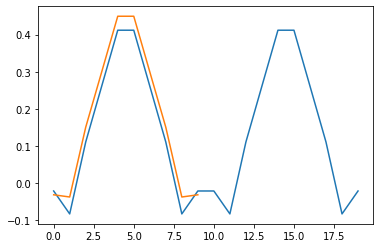

In [26]:
pl.plot(sysparams.xlattice, KSvals.vks-sharedvals.v1, sysparams.xlattice[:n_pts_s], -0.1+result.x/np.sqrt(np.diag(one_rdm))-vinit1l[:n_pts_s])
#pl.plot(sharedvals.vinteract)

In [27]:
print(fsum)

0.017657522718198218


In [28]:
psifin = np.zeros(len(fullvals.psi), dtype=np.complex128)
sharedvals.v1[:] = vfin1l
td.secondquant_wrap.calc_ground_state(sysparams, sharedvals, 2*n_pts_s, 30, psifin)

 infunction
 eig   6.6928353912013305        7.6589032118078517        7.6589032118078579        7.6589032118078677        7.7415287753279163     


1.1005712222763075e-05
5.4999999998517755


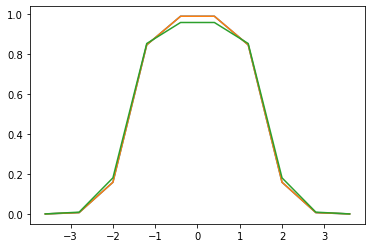

In [29]:
E, V = np.linalg.eigh(tfft.real+np.diag(KSvals.vks[:n_pts_s]))#np.diag(result.x/np.sqrt(np.diag(one_rdm))))
td.density.fullwf_density(sysparams,fullvals.psi,dpenew)
dpesum = np.zeros(n_pts_s)
for i in range(n_pts_s):
    dpesum[i] = dpenew[i]+dpenew[i+n_pts_s]
pl.plot(dvrpts_s, dpesum, dvrpts_s, 2*V[:,0]**2+2*V[:,1]**2, dvrpts_s, np.diag(one_rdm))
print(np.linalg.norm(dpesum-2*V[:,0]**2-2*V[:,1]**2))
print(E[0]*2+E[1]*2)
#print('over', np.abs(np.dot(wavesf[:,0], psinew)))
#goales,waves = eigsh(t2+np.diag(vin+vksnew), k=2, which='SA')
#print(goales)
#print(goalf)
#print(2*np.dot(V[:,0],sysparams.t@V[:,0]+vext_final1*V[:,0])-goales[0]-exc-fsum)
adiafinal = 2*np.dot(V[:,0],tfft.real@V[:,0]+v1cur[:n_pts_s]*V[:,0])+2*np.dot(V[:,1],tfft.real@V[:,1]+v1cur[:n_pts_s]*V[:,1])+fsum
#print(2*np.dot(V[:,0],sysparams.t@V[:,0]+vext_final1*V[:,0])-goales[0]-exc+fsum)

In [30]:
adiainit = 2*np.dot(phi[:,0],tfft.real@phi[:,0]+vpot_harm(dvrpts_s, 1)*phi[:,0])+2*np.dot(phi[:,1],tfft.real@phi[:,1]+vpot_harm(dvrpts_s, 1)*phi[:,1])

In [31]:
adiafinal-adiainit

0.21160571466905154

In [32]:
6.6928353912013305-6.4812311987794651

0.21160419242186546

In [33]:
0.21160571466905154-0.21160419242186546

1.5222471860809605e-06